## Index

* [1 - Imports](#1)
* [2 - Load the data](#2)
* [3 - Define Functions](#3)
* [4 - Model](#4)

## Import <a class="anchor" id="1"></a>

In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

import requests

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import calibration_curve

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import log_loss

# from imblearn.over_sampling import SMOTENC
# from imblearn.combine import SMOTETomek

from sklearn.metrics import roc_curve, auc

from category_encoders import LeaveOneOutEncoder

import xgboost

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import datetime


%matplotlib inline

## Load files  <a class="anchor" id="2"></a>

In [2]:
with open('dtypes_pre_process.pickle', 'rb') as fh:
    dtypes_pre = pickle.load(fh)
df_clean_path = '../capstone_train/df_clean.csv'
df_clean = pd.read_csv(df_clean_path, index_col=0).astype(dtypes_pre)
df_clean

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,...,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,cluster,hour,month,day_of_week,target
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,Person search,2019-12-01 00:00:00,True,NaN,NaN,Male,18-24,Asian/Asian British - Any other Asian background,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,Person search,2019-12-01 00:09:00,True,NaN,NaN,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,Person search,2019-12-01 00:10:00,True,NaN,NaN,Female,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,Person search,2019-12-01 00:10:00,False,NaN,NaN,Male,18-24,NaN,Asian,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,NaN,0,12,Sunday,0
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,Person search,2019-12-01 00:12:00,True,50.368247,-4.126646,Male,18-24,NaN,White,...,Controlled drugs,A no further action disposal,NaN,False,devon-and-cornwall,devon-and-cornwall1,0,12,Sunday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660606,a23dc59d-29fe-48e5-b012-81feb6acfddf,Person search,2018-08-29 02:45:00,False,NaN,NaN,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,NaN,2,8,Wednesday,0
660607,425fde18-f7d5-4ebe-baf4-714cadd5a445,Person and Vehicle search,2018-08-29 21:00:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,Penalty Notice for Disorder,True,False,wiltshire,wiltshire8,21,8,Wednesday,1
660608,7c249ab7-d4bf-47ef-86bd-aad51d7d2aab,Person search,2018-08-29 21:10:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0
660609,4fa54513-20c4-4a53-a5db-8a4bb85b1e32,Person search,2018-08-29 21:15:00,False,51.540219,-1.764708,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,...,Controlled drugs,A no further action disposal,NaN,False,wiltshire,wiltshire8,21,8,Wednesday,0


## Define functions  <a class="anchor" id="3"></a>

In [3]:
class MyLEncoder(BaseEstimator, TransformerMixin):

    # Save the enc during fitting
    def fit(self, X, y, **fit_params):
        enc = LeaveOneOutEncoder()
        self.enc = enc.fit(np.asarray(X), y)
        return self

    def transform(self, X, **fit_params):
        enc_data = self.enc.transform(np.asarray(X))
        return enc_data

    def get_feature_names(self, **fit_params):
        feature_list = self.enc.get_feature_names()
        return feature_list

In [4]:
def verify_no_discrimination(X_test, y_test, y_pred, sensitive_class, min_samples, max_diff=0.05):
    
    def calculate_discrimination(X_test, y_true, y_pred, sensitive_column, min_samples, max_diff):
        departments = X_test['station'].unique()
        sensitive_classes = X_test[sensitive_column].unique()
        
        # station success for each sensitive class
        problematic_departments = []
        good_deparments = []
        ignored_departments = []
        for department in departments:
            precisions = {}
            
            #  calculate precision
            for sensitive_class in sensitive_classes:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    mask = mask.astype(bool) 
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

            # classify department performance based on precision difference between classes
            if len(precisions) > 1:    
                diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
                if diff > max_diff:
                    problematic_departments.append((department, diff, precisions))
                else:
                    good_deparments.append((department, diff, precisions))
            else:
                ignored_departments.append((department, None, []))

        
        # global success for each sensitive class
        global_precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class)
            if np.sum(mask) > min_samples:
                mask = mask.astype(bool)
                global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)

                
        return problematic_departments, good_deparments, ignored_departments, global_precisions
              
    #
    #
    #
    
    print(f"{sensitive_class}")

    problematic_departments, good_deparments, ignored_departments, global_precisions = calculate_discrimination(
        X_test, y_test, y_pred, sensitive_class, min_samples, max_diff)

    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments))) 
    
    problematic_sorted = sorted(problematic_departments, key=lambda tup: tup[1], reverse=True)
    good_sorted = sorted(good_deparments, key=lambda tup: tup[1], reverse=True)
    
    return problematic_sorted, good_sorted, ignored_departments

In [66]:
def verify_success_per_station_per_objective(X_test, y_true, y_pred, min_samples = 30):
    stations = X_test['station'].unique()
    
    obj_column = 'Object of search'
    objectives = X_test[obj_column].unique()
  
    station_objs_precison = {}
    station_avg_precison = {}

    for station in stations:
        mask = X_test['station'] == station
        mask = mask.astype(bool) 
        station_avg_precison[station] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
        
        objectives_precision = {}
        
        #  calculate precision
        for obj in objectives:
            mask = (X_test[obj_column] == obj) & (X_test['station'] == station)
            if np.sum(mask) > min_samples:
                mask = mask.astype(bool) 
                objectives_precision[obj] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        station_objs_precison[station] = objectives_precision 
        
    list_station_precision = []
    
    for station in station_objs_precison:
        for obj in station_objs_precison[station]:
            row = [station, obj, station_objs_precison[station][obj]]
            list_station_precision.append(row)
    
    df_sta_obs_prec = pd.DataFrame(columns=['station', 'Object of search', 'precision'], data=list_station_precision)
    df_sta_obs_prec = df_sta_obs_prec[df_sta_obs_prec.precision != 0].sort_values(by='precision', ascending='True')
    
    station_avg_precison_sorted = dict(sorted(station_avg_precison.items(), key=lambda item: item[1]))
    station_avg_precison_sorted = pd.DataFrame(columns=['station', 'precision'], data=station_avg_precison.items())
    station_avg_precison_sorted = station_avg_precison_sorted[station_avg_precison_sorted.precision != 0].sort_values(by='precision', ascending='True')
    
    return df_sta_obs_prec, station_avg_precison_sorted

In [6]:
#Get the confusion matrix
def confusion_matrix_plot(y_test, y_pred_threshold):
    cf_matrix = confusion_matrix(y_test, y_pred_threshold)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    fig = plt.subplots(figsize=(8,8))         # Sample figsize in inches
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', linewidths=10, annot_kws={"size": 12})
    
    return cf_matrix

In [7]:
def precision_recall_plot(y_test, y_pred, min_precision):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    precision = precision[:-1]
    recall = recall[:-1]
    
    fig=plt.figure(figsize=(6,6))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    ax1.hlines(y=min_precision,xmin=0, xmax=1, colors='red')
    ax1.plot(thresholds, precision)
    ax2.plot(thresholds, recall)
    ax1.get_shared_x_axes().join(ax1, ax2)
    ax1.set_xticklabels([])
    ax1.set_title('Precision')
    ax2.set_title('Recall')
    plt.xlabel('Threshold')
    plt.show()
    
    min_index = [i for i, prec in enumerate(precision) if prec >= min_precision][0]
    print('optimal_threshold[min_index]: ', round(thresholds[min_index],3))
    print('precision[min_index]: ', round(precision[min_index],3))
    print('recall[min_index]: ', round(recall[min_index],3))

In [8]:
def calibration_plot(y_test, y_pred, n_bins, normalize):
    g_y, g_x = calibration_curve(y_test, y_pred, n_bins=n_bins, normalize=normalize)

    fig, ax = plt.subplots()
    fig.suptitle( 'Calibration plot')

    plt.plot(g_x,g_y, marker='o', linewidth=1, label='g')

    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')

    plt.legend(); plt.show()

In [9]:
def bin_total(y_test, y_pred, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_pred, bins) - 1

    return np.bincount(binids, minlength=len(bins))

In [10]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    recall = recall_score(y_true, y_pred, pos_label=True)    
    return recall

In [11]:
def roc_curve_plot(y_true, y_pred):
    roc = roc_auc_score(y_test, y_pred)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    plt.figure()
    lw = 2
    plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - Precision')
    plt.ylabel('True Positive Rate - Recall')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

## Model   <a class="anchor" id="4"></a>

In [12]:
# Exclude 'Age range', 'Self-defined ethnicity', 'observation_id','Removal of more than just outer clothing', 'Latitude'/'Longitude'
# 'Gender', 'Officer-defined ethnicity'
all_features = ['station', 
                'Type',
                'Part of a policing operation',
                'Object of search', 
                'Legislation', 
                'day_of_week', 
                'hour', 
                'month', 
                'cluster', ]
                #'Age range', 'Gender', 'Officer-defined ethnicity']
numerical_features = ['hour', 'month']
categorical_features = [ 'Object of search', 
                        'Legislation', 
                        'Type', 
                        'Part of a policing operation', 
                        'station', 
                        'day_of_week','cluster', ]
                        #'Age range', 'Gender', 'Officer-defined ethnicity']
#categorical_features2 = ['cluster']
target = 'target'

In [13]:
df_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean[target])

X_train = df_train[all_features]
y_train = df_train[target]

X_test = df_test[all_features]
y_test = df_test[target] 

In [14]:
# Try oversampling
# Obatin column index for categorical features
# cat_col_index = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
# smotenc = SMOTENC(categorical_features=cat_col_index, 
#                   random_state = 42, 
#                   sampling_strategy = 'minority', 
#                   k_neighbors=3, 
#                   n_jobs=-1)
# X_oversample_all, y_oversample_all = smotenc.fit_resample(X_train, y_train)

In [15]:
# X_oversample_model = X_oversample_all[all_features]

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])#MyLEncoder())])  ### # 

# categorical_transformer2 = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', MyLEncoder())])  ### # 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)]
        #('cat2', categorical_transformer2, categorical_features2)]
)

pipeline = make_pipeline(
    preprocessor,
    xgboost.XGBRegressor(random_state=42) #reg_alpha=1, objective = 'binary:logistic'
#     CalibratedClassifierCV(
#         xgboost.XGBClassifier(random_state=42, reg_alpha=0.8, scale_pos_weight=4, 
#                               objective = 'binary:logistic', eval_metric='logloss')
#     )
)

pipeline.fit(X_train, y_train)

#y_pred = pipeline.predict_proba(X_test) y_pred = [y[1] for y in y_pred]
y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

## Model evaluation   <a class="anchor" id="5"></a>

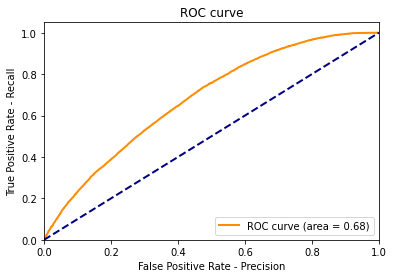

In [17]:
roc_curve_plot(y_test, y_pred)

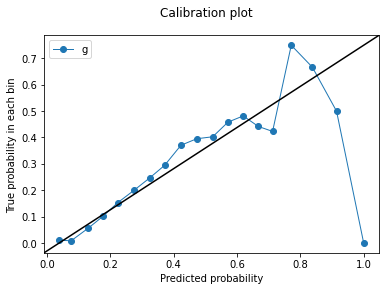

In [18]:
calibration_plot(y_test, y_pred, n_bins=20, normalize=True)

In [19]:
# bin_total(y_test, y_pred, n_bins=15)
# brier_score_loss(y_test, y_pred, pos_label=2)

In [20]:
# # model validation
# n_splits , n_repeats = 5,3
# cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)
# print(cross_val_score(pipeline, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)) # n_splits * n_repeats scores
# # auc_roc stable around 0.67

### Find optimal threshold

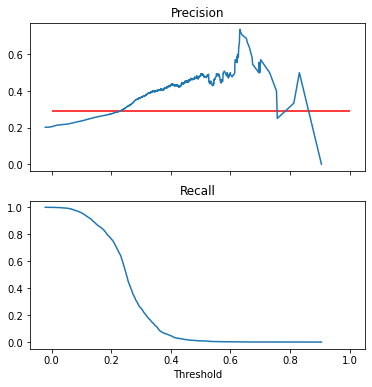

optimal_threshold[min_index]:  0.227
precision[min_index]:  0.288
recall[min_index]:  0.662


In [21]:
# find otimal prediction probablity threshold for a precision minimum
min_precision = 0.288
precision_recall_plot(y_test, y_pred, min_precision)

In [22]:
optimal_threshold  = 0.228 #0.228
y_pred_threshold = np.array(list(map(lambda x: 1 if x > optimal_threshold else 0, y_pred)))


### performance metrics

In [23]:
print(classification_report(y_test, y_pred_threshold))

              precision    recall  f1-score   support

           0       0.87      0.59      0.70     49221
           1       0.29      0.66      0.40     12405

    accuracy                           0.60     61626
   macro avg       0.58      0.62      0.55     61626
weighted avg       0.76      0.60      0.64     61626



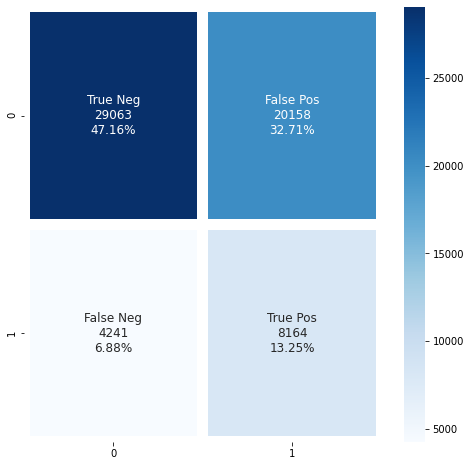

In [24]:
conf_matrix = confusion_matrix_plot(y_test, y_pred_threshold)

### requirements metrics

#### discrimnation

In [25]:
problematic_stations_g, good_stations_g, ignored_stations_g = verify_no_discrimination(df_test, y_test, y_pred_threshold, 'Gender', 30)

Gender
Global rates: {'Male': 0.2930018850141376, 'Female': 0.24614845938375352}
Num problematic departments: 26
Num good departments: 13
avg diff: 0.13356625801121888
Departments analysed: 39


/home/hrkbaltazar/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
print("Expected max diff between Genders in each station")
for i in problematic_stations_g[0:2]:
    print("\n", i[0],": ", round(i[1]*100,2),"%")
    for u in i[2]:
        print(u, round(i[2][u]*100,2))

Expected max diff between Genders in each station

 dyfed-powys :  66.67 %
Male 33.33
Female 100.0

 bedfordshire :  28.12 %
Male 34.78
Female 6.67


In [27]:
problematic_stations_e, good_stations_e, ignored_stations_e = verify_no_discrimination(df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 40)

Officer-defined ethnicity
Global rates: {'White': 0.284892861955887, 'Other': 0.3050847457627119, 'Black': 0.29822866344605475, 'Asian': 0.30276497695852533, 'Mixed': 0.3010204081632653}
Num problematic departments: 24
Num good departments: 6
avg diff: 0.13100294292773162
Departments analysed: 30


In [28]:
print("Expected max diff between Ethnicties in each station")
for i in problematic_stations_e[0:2]:
    print("\n", i[0],": ", round(i[1]*100,2),"%")
    for u in i[2]:
        print(u, round(i[2][u]*100,2))

Expected max diff between Ethnicties in each station

 leicestershire :  31.82 %
White 32.73
Black 18.18
Asian 50.0

 lancashire :  26.0 %
White 25.68
Black 0.0
Asian 26.0


#### minimum success per station/objective and maximum average success rate between station

In [67]:
df_station_obs_precision, station_avg_precison = verify_success_per_station_per_objective(df_test, y_test, y_pred_threshold, 1)
df_station_obs_precision.head()

/home/hrkbaltazar/.virtualenvs/capstone/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,station,Object of search,precision
270,cleveland,Offensive weapons,0.047619
72,northumbria,Offensive weapons,0.090909
238,gloucestershire,Stolen goods,0.100000
259,west-mercia,Offensive weapons,0.117647
214,btp,Articles for use in criminal damage,0.125000


In [70]:
display(station_avg_precison[:5])
display(station_avg_precison[-5:])

,station,precision
36,north-yorkshire,0.142857
0,north-wales,0.171875
38,wiltshire,0.200000
15,thames-valley,0.222222
39,cumbria,0.225564


,station,precision
2,city-of-london,0.340278
40,cambridgeshire,0.352941
3,leicestershire,0.362637
29,durham,0.373016
4,dyfed-powys,0.400000


In [75]:
# top feature importance
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

xgb_regressor_step = pipeline.named_steps['xgbregressor']
importances = pd.Series(data=xgb_regressor_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(10):
    feature_name = importances.index[indices[f]]
    
    print(f"{f+1}. {feature_name} ({importances[indices[f]]})")

Feature ranking:
1. station_dyfed-powys (0.058588478714227676)
2. station_humberside (0.035579606890678406)
3. station_thames-valley (0.03014962002635002)
4. station_south-yorkshire (0.02893012948334217)
5. station_leicestershire (0.02260110341012478)
6. Type_Person search (0.02224690094590187)
7. station_merseyside (0.02199246548116207)
8. Object of search_Controlled drugs (0.0213815625756979)
9. station_lancashire (0.019116757437586784)
10. station_durham (0.018261410295963287)


###  Models comparison

| Model |   Baseline    |  Second iteration   |  Third iteration   | Best model |
|-------------------|---------|--------|--------|--------| 
| Requirement 1 - success rate |     0.33  |  0.27  |  0.29  |1 |
| Requirement 2 - global discrimination (gender) | 0.22  | 0.12 |  0.12  |2=3 |
| Requirement 2 - global discrimination (ethnicity) | 0.18  |  0.10   |  0.12  |2 | 
| Requirement 2 - nº of station discrimination above 5% (gender) | 26 |  24 |  24  |2=3 |
| Requirement 2 - nº of station discrimination above 5% (ethnicity) | 30 |  22  |  25  | 2 |

# save model

In [32]:
# with open('columns.json', 'w') as fh:
#     json.dump(X_train.columns.tolist(), fh)
# joblib.dump(pipeline, 'pipeline.pickle')
# with open('dtypes.pickle', 'wb') as fh:
#     pickle.dump(X_train.dtypes, fh)

### Send observations from CSV file

In [33]:
# df_predictions = pd.read_csv("../capstone_train/day_10_bk.csv", sep=",")

### should_search

In [34]:
# url = "http://localhost:5000/should_search/" # https://capstone-henrique.herokuapp.com # http://localhost:5000
# headers = {'Content-Type': 'application/json'}

In [35]:
# def send_request(observation, url: str, headers: dict):
#     r = requests.post(url, data=json.dumps(observation), headers=headers)
#     result = json.loads(r.text)
#     return result

In [36]:
# for row in df_predictions[4:5].iterrows():

#     observation = row[1][2]
#     res = json.loads(observation) 
#     date = pd.to_datetime(res['Date'][:19], infer_datetime_format=True)
#     print(observation)
#     send_request(res, url, headers)

### search-result

In [37]:
# url = "https://capstone-henrique.herokuapp.com/search_result/" # https://capstone-henrique.herokuapp.com # http://localhost:5000
# headers = {'Content-Type': 'application/json'}

In [38]:
# df_pred_update = df_predictions[:35][['observation_id', 'outcome']] #35
# df_pred_update.to_dict('records')

In [39]:
# df_pred_ready = df_pred_update.to_dict('records')
# for obs in df_pred_ready:
#     obs_clean = str(obs).replace('False','false').replace('True','true').replace('\'','\"') #
#     res = json.loads(obs_clean) 
#     print(res)
#     send_request(res, url, headers)